# MCMC Comparison

## surmise

1. Train a GP (using surmise) to emulate the ${}^3{\rm He}(\alpha,\gamma)$ observables. 
2. Use that GP to calculate the $R$-matrix parameter posteriors.
3. Compare to the results in our BRICK paper.


* CS model
* maximally 1000 training points

In [1]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
import emcee
import dill as pickle

import model

In [2]:
plt.style.use('science')
gr = (1 + np.sqrt(5)) / 2
h = 3

plt.rcParams['figure.dpi'] = 150

In [3]:
b = emcee.backends.HDFBackend('emulators/backends/eps_1.0000e-02_ntrain_500_fat_0.3.h5')

with open('emulators/emu_eps_1.0000e-02_ntrain_500_fat_0.3.pkl', 'rb') as f:
    emu = pickle.load(f)

In [4]:
emu._info['pc'].shape

(500, 95)

In [5]:
chain = b.get_chain()

In [6]:
lnp = b.get_log_prob()

In [7]:
lnp[0]

array([-2.67908684e+02,  1.92385471e+02,  1.96338666e+02,  3.68296868e+01,
        1.96798038e+02,  2.93451715e+02, -8.06714023e+02,  3.08362066e+02,
        1.24974997e+02,  1.50731028e+02, -5.95747690e+01,  2.42082723e+02,
        2.57143491e+02,  4.99196364e+01,  1.39929952e+02, -6.89330161e+02,
       -2.69324881e+03, -5.96595667e+02, -1.89459268e+02,  2.68393493e+02,
        2.68680572e+02, -1.35971724e+02,  3.36149170e+02,  1.40837428e+02,
       -3.60092378e+02, -8.56948916e+01,  2.82626466e+02,  1.13740449e+02,
        3.86508526e+02,  6.67978773e+01,  1.09801250e+02,  1.40357791e+02,
        6.87025849e+01, -1.88354826e+02,  2.19492235e+02,  2.00711901e+02,
        1.63155689e+02,  2.86129005e+02, -9.77946889e+02,  2.52682654e+02,
        4.16346407e+02,  2.23839880e+02,  3.56886504e+01,  2.31069121e+01,
        4.07400244e+02,  1.92688868e+02, -2.52768732e+02, -1.33963863e+02,
        1.61590009e+02, -1.16171890e+02,  1.99654169e+02,  1.36159999e+02,
       -3.00216573e+02, -

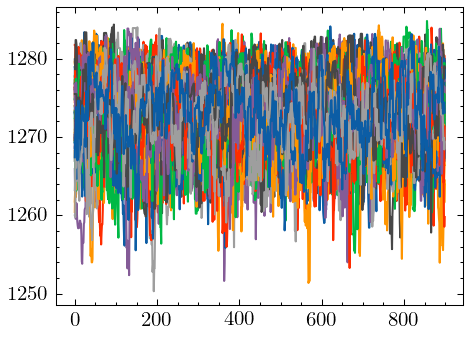

In [9]:
nb = 100
cutoff = -np.inf

ii = np.where(np.min(lnp[nb:, :], axis=0) > cutoff)[0]

plt.plot(lnp[nb:, ii]);

In [10]:
design_chain = np.load('datfiles/fat_0.3_posterior_chain.npy')

def plot_chain_summary(ch, ax):
    low, med, high = np.quantile(ch, [0.16, 0.5, 0.84])
    ax.axhspan(low, high, color='C1', alpha=0.5)
    ax.axhline(med, color='C1')

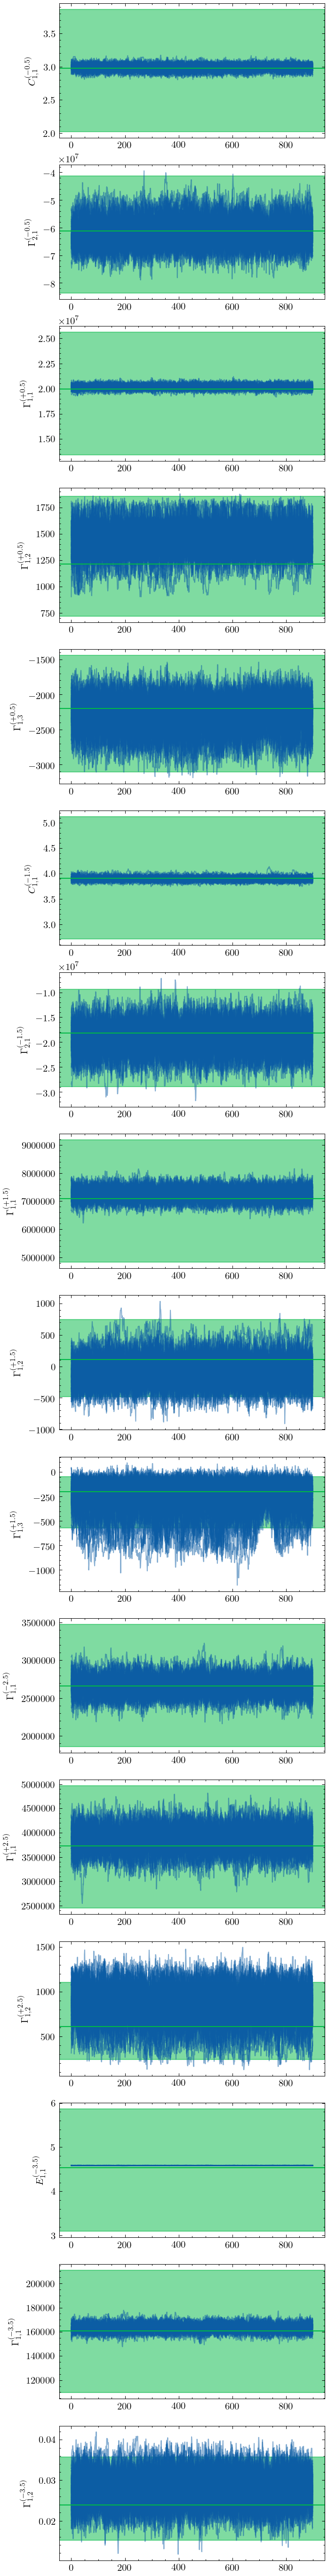

In [11]:
fig, ax = plt.subplots(model.nrpar, figsize=(gr*h, model.nrpar*h))
fig.patch.set_facecolor('white')

for i in range(model.nrpar):
    ax[i].plot(chain[nb:, ii, i], alpha=0.5, color='C0')
    ax[i].set_ylabel(model.azr.config.labels[i])
    plot_chain_summary(design_chain[:, i], ax[i])

In [12]:
# fig, ax = plt.subplots(model.nf_capture, 
#                        figsize=(gr*h, model.nf_capture*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar, model.nrpar + model.nf_capture)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [13]:
# fig, ax = plt.subplots(model.nf_scatter, 
#                        figsize=(gr*h, model.nf_scatter*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar + model.nf_capture, model.ndim)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [14]:
n1 = model.nbr
n2 = model.nxs

In [15]:
flat_chain = b.get_chain(flat=True)
lnp = b.get_log_prob(flat=True)
theta_star = flat_chain[np.argmax(lnp), :]

In [16]:
lnp[np.argmin(lnp)]

-4553.602901607356

In [17]:
lnp.shape

(64000,)

In [18]:
theta_bad = flat_chain[np.argmin(lnp), :]

In [19]:
np.argmin(lnp)

63

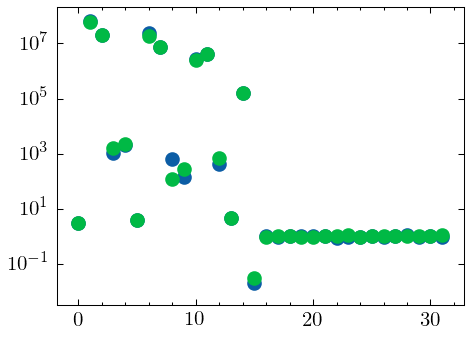

In [20]:
plt.scatter(np.arange(theta_bad.size), np.abs(theta_bad))
plt.scatter(np.arange(theta_star.size), np.abs(theta_star))
plt.yscale('log');

In [21]:
from bayes import ln_prior, Model2

In [22]:
m = Model2(emu)

In [23]:
m.ln_likelihood(theta_bad)

-5713.109101596833

In [24]:
m.ln_likelihood(theta_star)

963.5096381521197

In [25]:
print(f'{m.ln_likelihood(theta_bad, include_gp_var=False):.4e}')
print(f'{m.ln_likelihood(theta_star, include_gp_var=False):.4e}')

-1.2778e+05
1.1657e+03


In [26]:
from multiprocessing import Pool

In [27]:
with Pool(processes=16) as pool:
    lnpi = pool.map(ln_prior, flat_chain)

In [28]:
lnpi = np.array(lnpi)

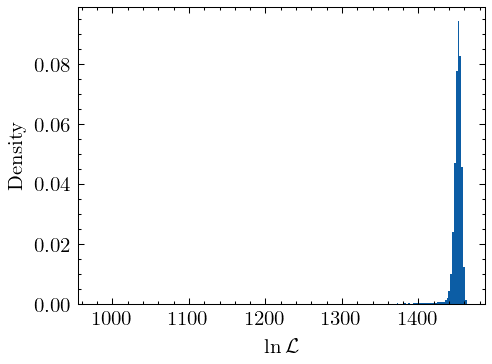

In [29]:
plt.hist(lnp[500:] - lnpi[500:],bins=200, density=True)
# plt.xlim([-1000, 750])
plt.xlabel('$\ln\mathcal{L}$')
plt.ylabel('Density');

In [30]:
mu_star = model.calculate_norm(theta_star)
mu_bad = model.calculate_norm(theta_bad)

In [31]:
def plot_prediction(theta, ax, start, stop, color='C2', label=None):
    p = emu.predict(theta=theta[:16])
    mu = p.mean().flatten()
    var = p.var().flatten()
    ax.errorbar(model.x[start:stop], mu[start:stop], yerr=np.sqrt(var[start:stop]),
                linestyle='', capsize=2, color=color, marker='x', alpha=0.5, label=label)

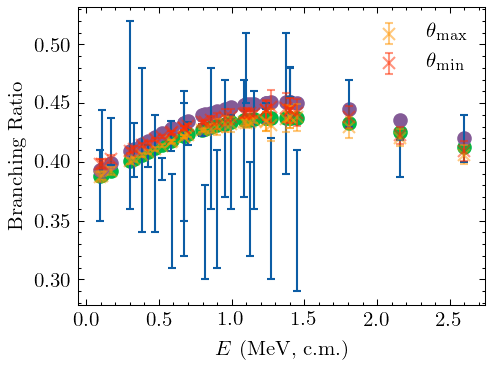

In [32]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[:n1], model.y[:n1], yerr=model.dy[:n1], linestyle='', capsize=2)
ax.scatter(model.x[:n1], mu_star[:n1], color='C1')
ax.scatter(model.x[:n1], mu_bad[:n1], color='C4')

plot_prediction(theta_star, ax, 0, n1, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, 0, n1, color='C3', label=r'$\theta_{\min}$')
# ax.errorbar(model.x[:n1], mu_star_gp[:n1], yerr=np.sqrt(mu_star_gp_var[:n1]), linestyle='', capsize=2, color='C2')

ax.legend()
ax.set_ylabel('Branching Ratio')
ax.set_xlabel('$E$ (MeV, c.m.)');

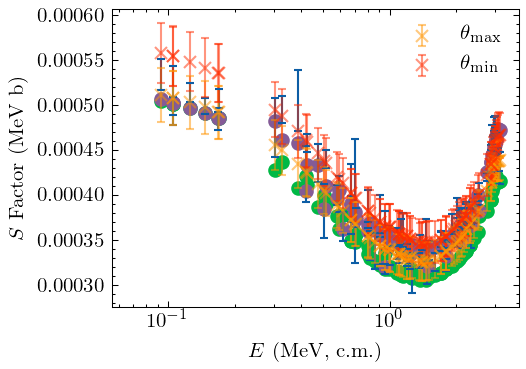

In [33]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1:n1+n2], model.y[n1:n1+n2], yerr=model.dy[n1:n1+n2], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1, n1+n2, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, n1, n1+n2, color='C3', label=r'$\theta_{\min}$')

ax.scatter(model.x[n1:n1+n2], mu_star[n1:n1+n2], color='C1')
ax.scatter(model.x[n1:n1+n2], mu_bad[n1:n1+n2], color='C4')

# ax.scatter(model.x[n1:n1+n2], 1000*mu_star[n1:n1+n2], color='C1')
# ax.errorbar(model.x[n1:n1+n2], 1000*mu_star_gp[n1:n1+n2], yerr=1000*np.sqrt(mu_star_gp_var[n1:n1+n2]), linestyle='',
#             capsize=2, color='C2')

ax.legend()
ax.set_ylabel('$S$ Factor (MeV b)')
ax.set_xlabel('$E$ (MeV, c.m.)')
ax.set_xscale('log');

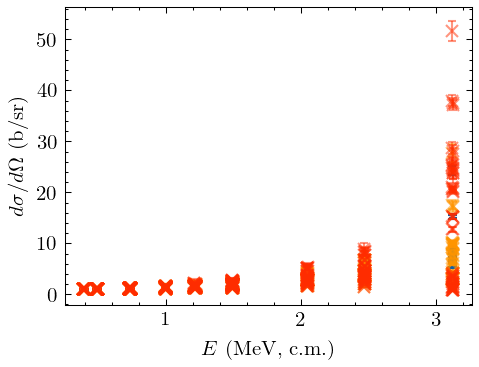

In [34]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1+n2:], model.y[n1+n2:], yerr=model.dy[n1+n2:], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1+n2, None, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, n1+n2, None, color='C3', label=r'$\theta_{\min}$')

# ax.scatter(model.x[n1+n2:], mu_star[n1+n2:], color='C1')
# ax.errorbar(model.x[n1+n2:], mu_star_gp[n1+n2:], yerr=np.sqrt(mu_star_gp_var[n1+n2:]), linestyle='',
#             capsize=2, color='C2')

ax.set_ylabel(r'$d\sigma/d\Omega$ (b/sr)')
ax.set_xlabel('$E$ (MeV, c.m.)');

In [35]:
b.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [17.8243508  17.22321434 12.39807139 19.77095999 19.95986187 17.9837788
 17.05803789 12.93856773 26.28236629 24.79952206 13.88669306 13.09781294
 22.52947724 14.0326831  13.73594191 14.86163345 14.95142426 13.42105605
 13.93818664 12.83689907 14.37904683 12.52960775  9.19177976 12.55518918
 12.9478058  11.33527024 12.22989894 11.27642643 12.49872121 12.26136216
 12.58524968 12.82056033]

In [36]:
from run import Run

In [37]:
import pickle

with open('/spare/odell/7Be/CP/samples/model_1_2021-08-06-02-55-37.pkl', 'rb') as f:
    run = pickle.load(f)

In [38]:
cs_flat_chain = run.get_flat_chain()

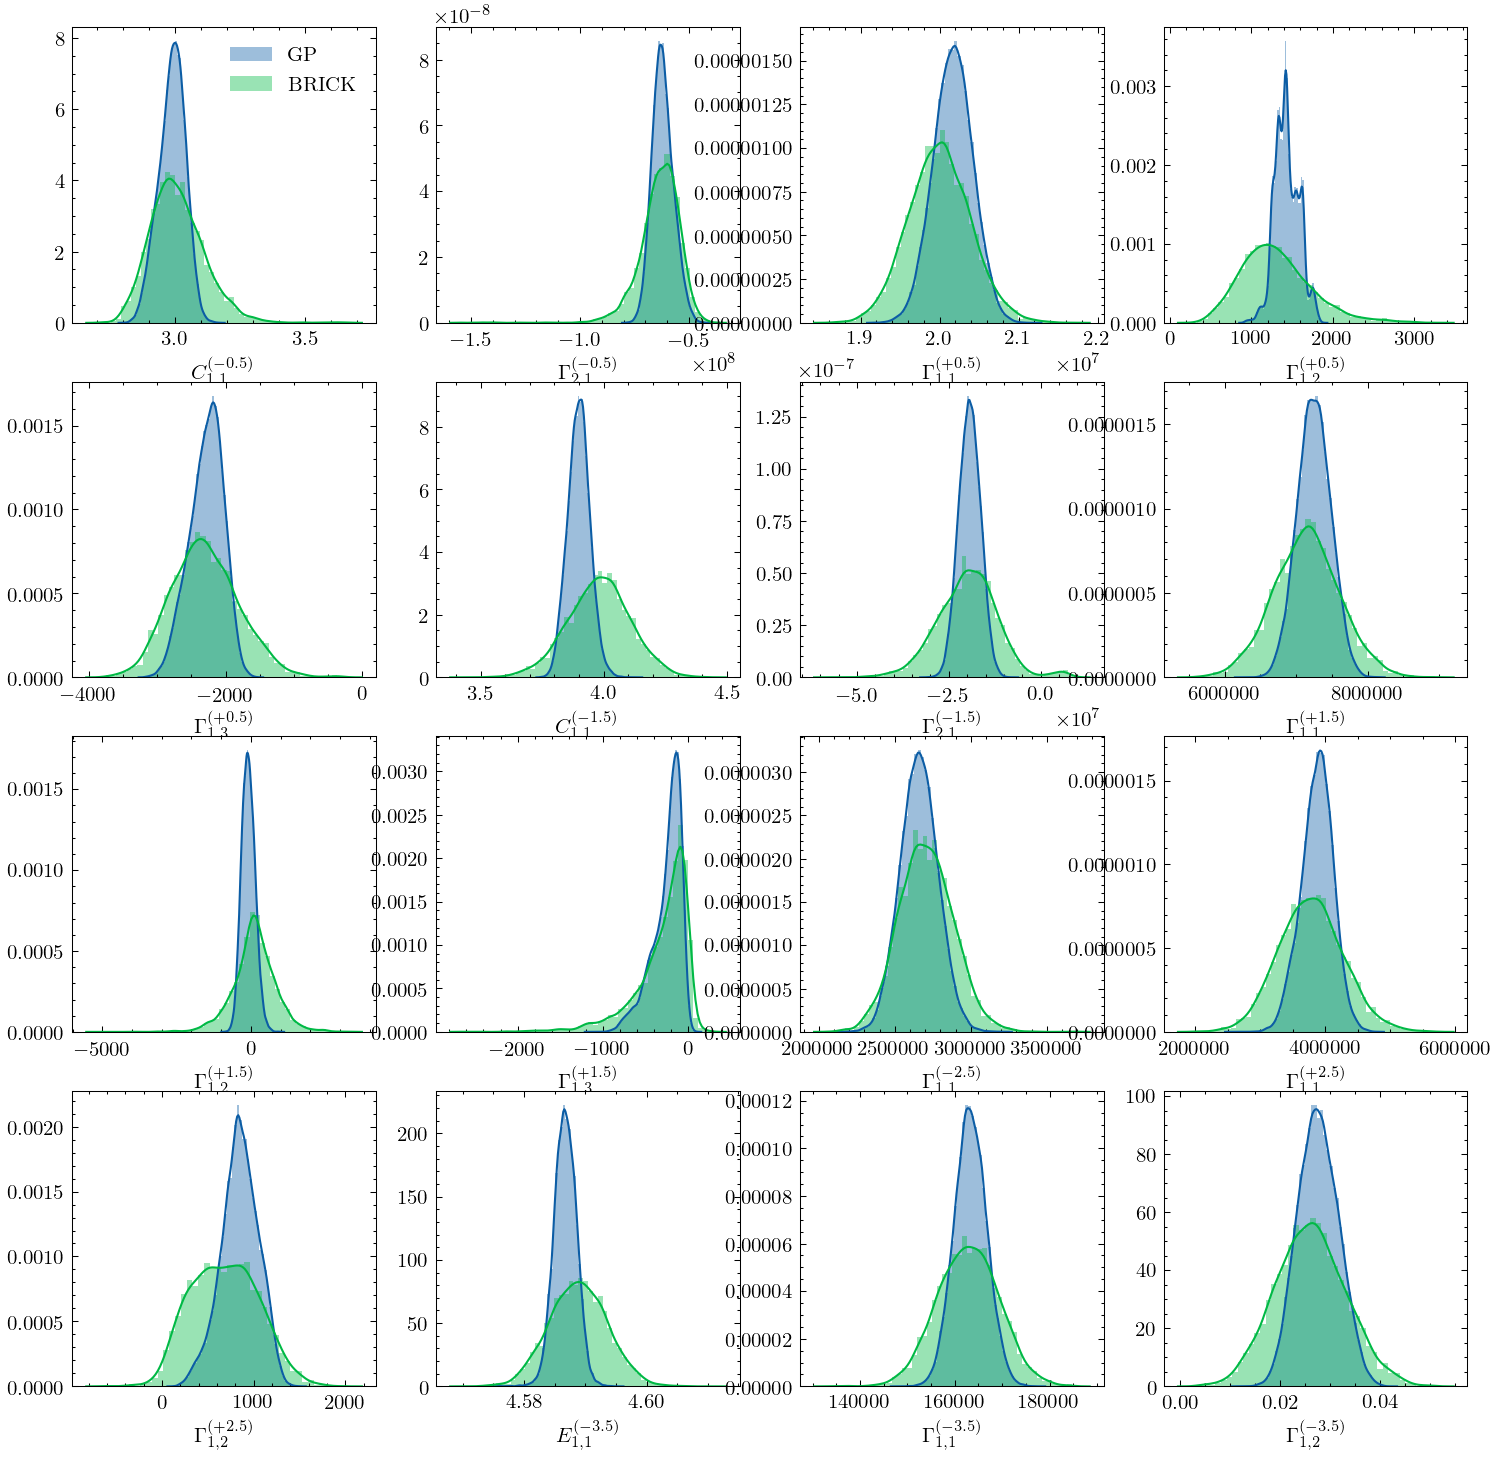

In [39]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = i*4 + j
        sns.distplot(chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel(model.azr.config.labels[k])
ax[0, 0].legend();

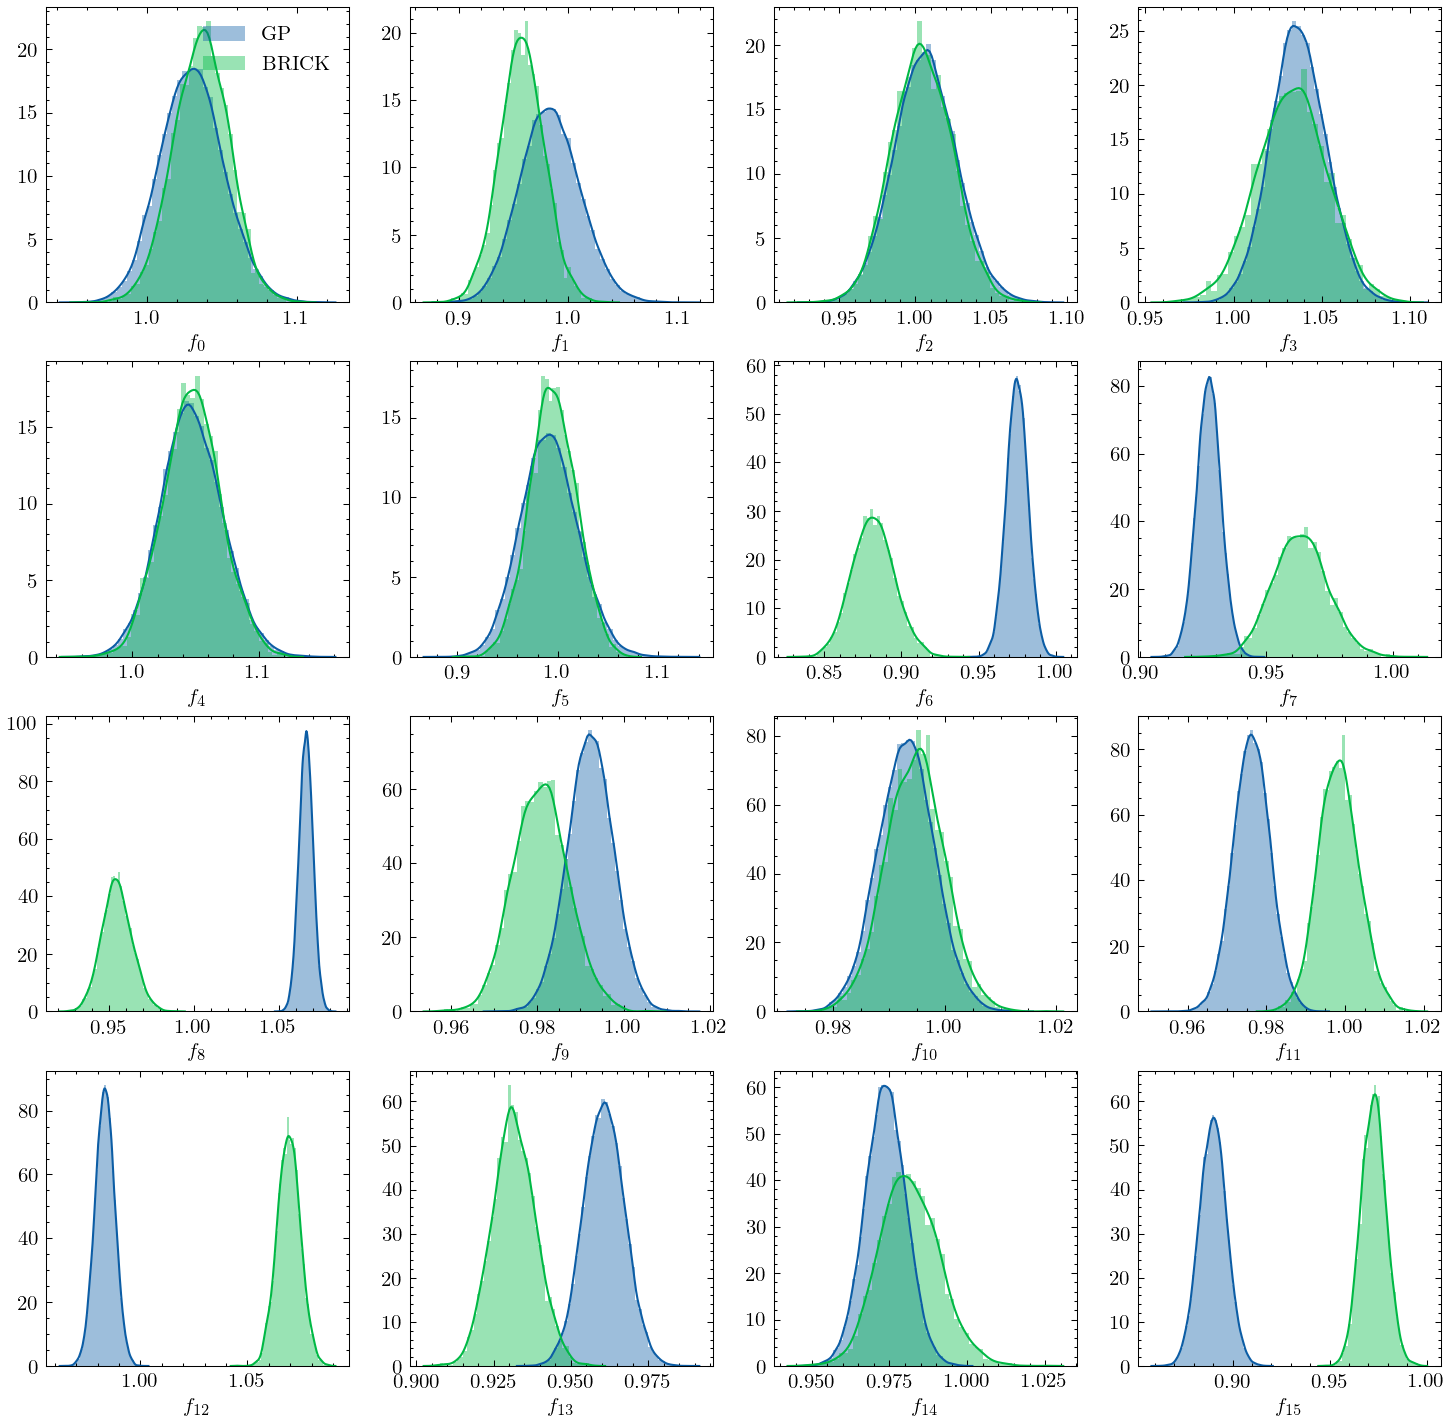

In [41]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = 16 + i*4 + j
        sns.distplot(1/chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel('$f_{%d}$' % (k-16))
ax[0, 0].legend();